Bone Masking

In [1]:
import cv2
from mayavi import mlab
import nibabel as nib
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from skimage.segmentation import watershed
from skimage.filters import gaussian
from skimage.morphology import skeletonize, opening, binary_opening, disk
from scipy.ndimage import zoom, binary_fill_holes, distance_transform_edt
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max


In [ ]:
ct_volume = nib.load("../results/3702_left_knee.nii.gz")
ct_data = ct_volume.get_fdata()
spacing = ct_volume.header.get_zooms()

In [288]:
def show_mask(mask):
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.show()

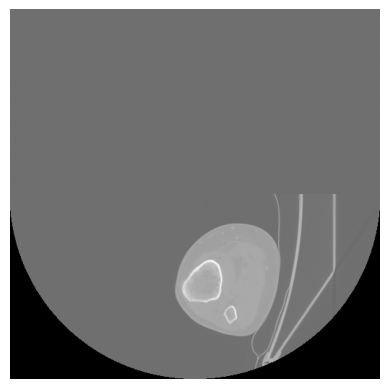

In [315]:
show_mask(ct_data[:, :, 80])

In [291]:
binary_mask = np.zeros_like(ct_data)

In [385]:
def mask_slice(i):
    slice = ct_data[:, :, i]
    zoom_in = zoom(slice, (4,4), order=0)
    blur = gaussian(zoom_in, sigma=2)
    _, thresh = cv2.threshold(blur, 180, 255, cv2.THRESH_BINARY) # 180 for slices 0-80, 240 for 80-90, 140-200 for 90--100
    zoom_out = zoom(thresh, (0.25, 0.25), order=0)
    return zoom_out

In [387]:
for i in range(130, 216):
    mask = mask_slice(i)
    filled_mask = binary_fill_holes(mask)   
    # opening = binary_opening(filled_mask, disk(1), mode="ignore")   # Morphological opening for removing lines and noises outside the region of interest while preserving small blobs
    clean_mask = remove_small_objects(filled_mask, min_size=800)    # Try different min_size such as 50, 100, 800, 1200 according to the slices

    # Use Distance Transform for slices 91 - 93
    # distance = distance_transform_edt(clean_mask, sampling=spacing[:2])
    # coords = peak_local_max(distance, footprint=np.ones((10,10)), labels=clean_mask)
    # mask = np.zeros(distance.shape, dtype=bool)
    # mask[tuple(coords.T)] = True
    # markers, _ = ndi.label(mask)
    # labels = watershed(-distance, markers, mask=clean_mask)
    # labels[labels == 2] = 0

    binary_mask[:, :, i] = clean_mask



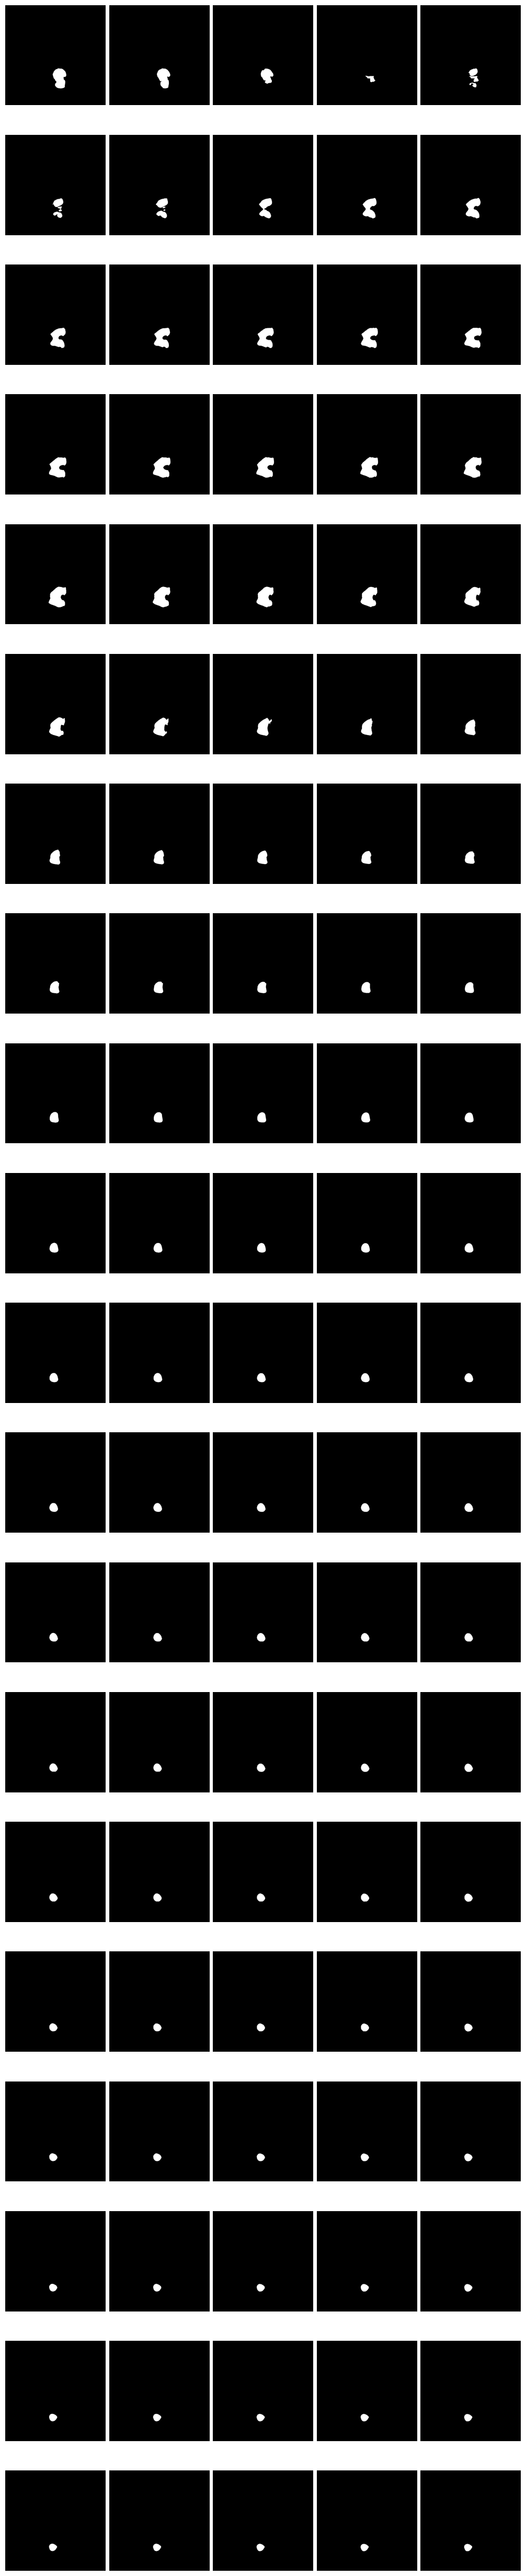

In [428]:
fig, axes = plt.subplots(20, 5, figsize=(10, 50))
for i, ax in enumerate(axes.flat):
    ax.imshow(binary_mask[:, :, 100 + i], cmap="gray")
    ax.axis("off")
plt.tight_layout(pad=0.5)
plt.show()

Text(0.5, 1.0, 'Sucessive zoom in and zoom out')

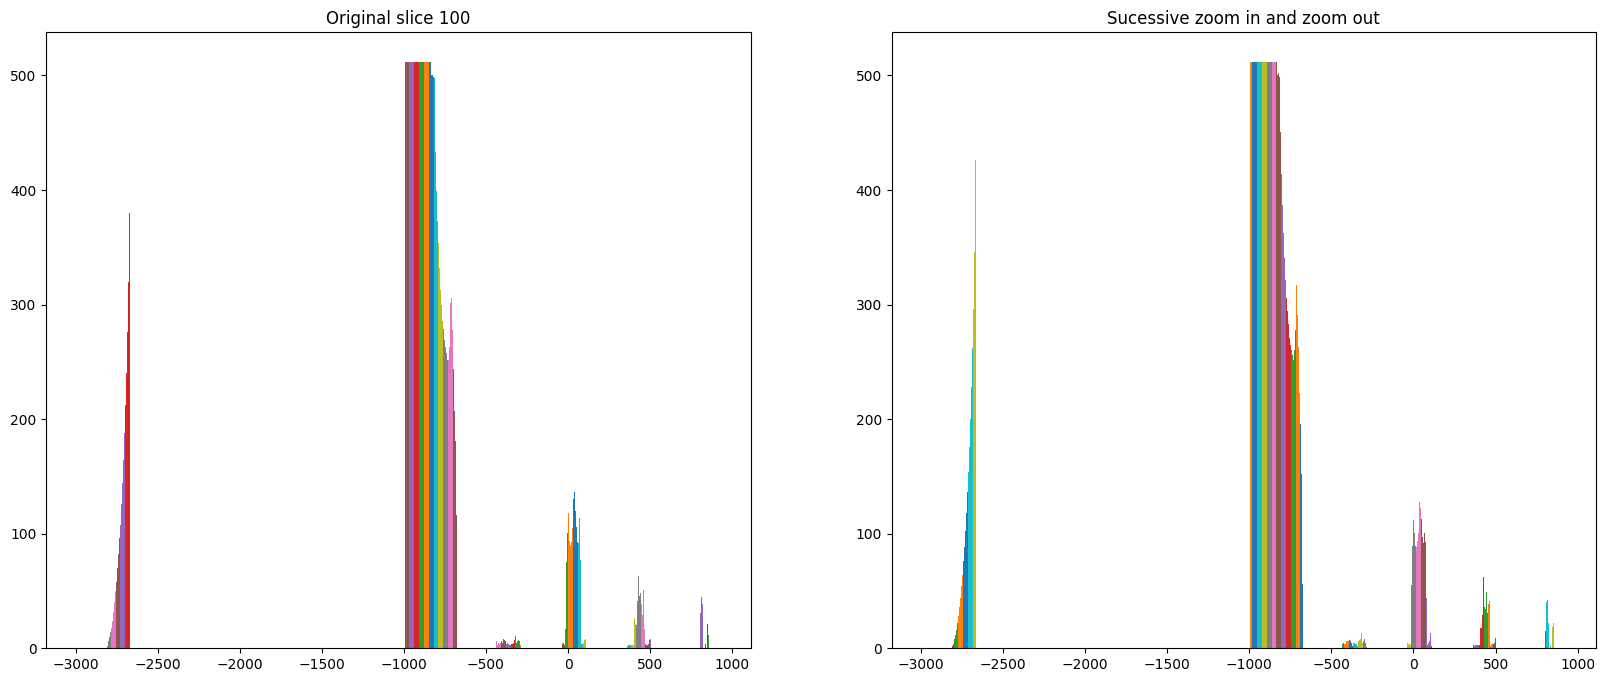

In [275]:
zoom_in = zoom(ct_data[100], (4,4), order=0)
zoom_out = zoom(zoom_in, (0.25, 0.25), order=0)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
ax = axes.ravel()
ax[0].hist(ct_data[100])
ax[0].set_title("Original slice 100")
ax[1].hist(zoom_out)
ax[1].set_title("Sucessive zoom in and zoom out")

In [ ]:
print(np.array_equal(ct_data[100], zoom_out)) # If True, the original slice and zoom_out is equal otherwise not.

True


In [389]:
nib.save(nib.Nifti1Image(binary_mask, affine=ct_volume.affine), filename="../results/3702_left_knee_mask_final.nii.gz")

Femur and Tibia Segmentation

In [2]:
mask_volume = nib.load("../results/3702_left_knee_mask_final.nii.gz")
mask_data = mask_volume.get_fdata()
volume_3d = np.stack(mask_data, axis=0)

In [3]:
mlab.contour3d(volume_3d, color=(1, 1, 1))
mlab.title("Original Mask")
mlab.show()

In [5]:
def watershed_segmentation(volume_3d):
    distance = distance_transform_edt(volume_3d.astype(bool))
    coords = peak_local_max(distance, footprint=np.ones((100,100,100)), labels=volume_3d.astype(bool))
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=volume_3d.astype(bool))
    return labels

In [6]:
labels = watershed_segmentation(volume_3d)

In [10]:
np.unique(labels[:, :, :104]), np.unique(labels[:, :, 108:])

(array([0, 1], dtype=int32), array([0, 2], dtype=int32))

In [8]:
nib.save(nib.Nifti1Image(labels, affine=mask_volume.affine), filename="../results/3702_left_knee_mask_segmented.nii.gz")

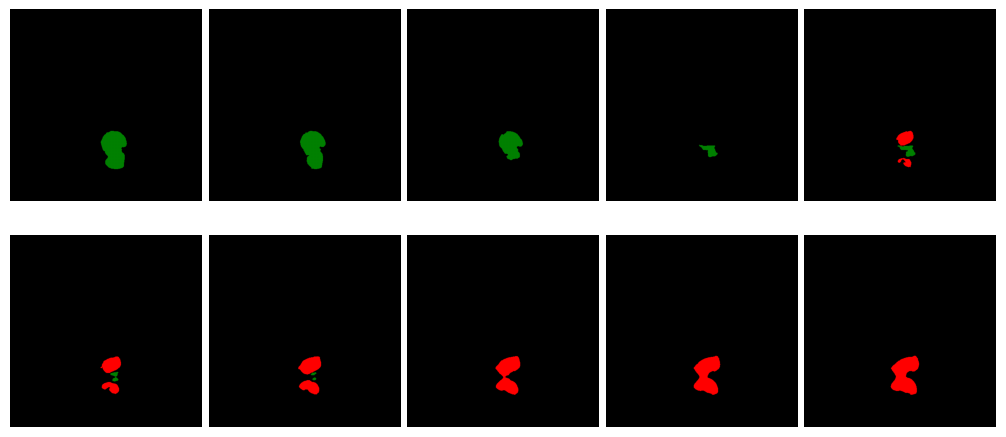

In [11]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['black', 'green', 'red'])
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(labels[:, :, i+100], cmap=cmap, vmin=0, vmax=2)
    ax.axis("off")
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
def visualize_segments(labels):

    tibia = (labels == 2).astype(np.float32)
    femur = (labels == 1).astype(np.float32)

    mlab.contour3d(tibia, color=(0, 1, 0))
    mlab.contour3d(femur, color=(1, 0, 0))
    mlab.title("Segmentation", size=1)
    mlab.show()

In [15]:
visualize_segments(labels)